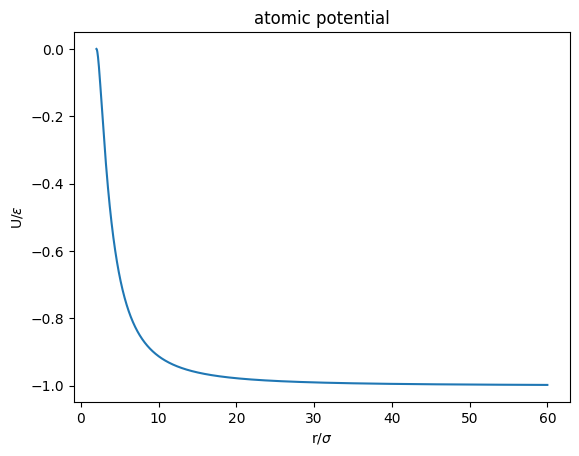

In [141]:
from itertools import combinations
from typing import Callable
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

def lj_potential(x: float) -> float:  # obfuscated, but fast implementation!
    r6 = 1 / x / x
    r6 *= r6 * r6
    return 4 * r6 * (r6 - 1)

def lj_potential_cut(x:float)->float:
    if x>=2.5:
        return 0
    else:
        return lj_potential(x)-lj_potential(2.5)


def pairwise_potential(potential: Callable[[float], float], xss: [[float]], box:float) -> float:
    """
    >>> lj13 = [
    ...     [  1.0132226417,  0.3329955686,  0.1812866397],
    ...     [   0.7255989775, -0.7660449415,  0.2388625373],
    ...     [   0.7293356067, -0.2309436666, -0.7649239428],
    ...     [   0.3513618941,  0.8291166557, -0.5995702064],
    ...     [   0.3453146118, -0.0366957540,  1.0245903005],
    ...     [   0.1140240770,  0.9491685999,  0.5064104273],
    ...     [  -1.0132240213, -0.3329960305, -0.1812867552],
    ...     [  -0.1140234764, -0.9491689127, -0.5064103454],
    ...     [  -0.3513615244, -0.8291170821,  0.5995701458],
    ...     [  -0.3453152548,  0.0366956843, -1.0245902691],
    ...     [  -0.7255983925,  0.7660457628, -0.2388624662],
    ...     [  -0.7293359733,  0.2309438428,  0.7649237858],
    ...     [   0.0000008339,  0.0000002733,  0.0000001488],
    ... ]
    >>> pairwise_potential(lj_potential, lj13)
    -44.326801418734654
    """
    
    Sum=0
    
    # box accounts for periodic boundary condition
    for xi,xj in combinations(xss,2):
        d=0
        for k in range(len(xi)):
            if xi[k]-xj[k]<-box/2:
                d+=(xi[k]+box-xj[k])**2
            elif xi[k]-xj[k]>box/2:
                d+=(xi[k]-box-xj[k])**2
            else:
                d+=(xi[k]-xj[k])**2
        Sum+=potential(d**0.5) 
    
    return Sum
    
def phi_A(r:float)->float:
    alpha=1
    rc=2.0
    r2=1/r**2
    if r>=rc:
        return 0
    else:
        return alpha*(r2-1)*(rc**2*r2-1)**2

def phi_A_derivative(r:float)->float:
    alpha=1
    rc=2.0
    r3=1/r**3
    rr=(rc/r)**2
    
    if r>=rc:
        return 0
    else:
        return 2*alpha*(rr-1)*(-3*rr+1+2*rc**2)
    
def phi_A_tail(r:float)->float:
    alpha=1
    rc=2.0
    r2=1/r**2
    return alpha*(r2-1)*(rc**2*r2-1)**2
    
    
def phi_A_tail_derivative(r:float)->float:
    alpha=1
    rc=2.0
    r3=1/r**3
    rr=(rc/r)**2
    return 2*alpha*(rr-1)*(-3*rr+1+2*rc**2)
    

x=np.linspace(2,60,2000)
fig, ax = plt.subplots()

ax.plot(x,[phi_A_tail(i) for i in x])
ax.set_title("atomic potential")
ax.set_xlabel("r/$\sigma$")
ax.set_ylabel("U/$\epsilon$")
plt.savefig("phi_A.png")

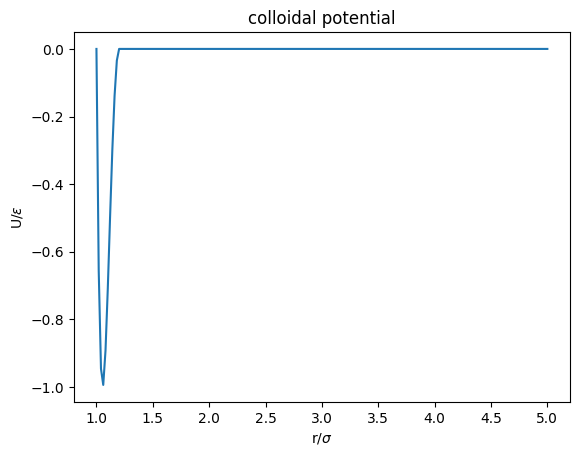

In [2]:
def phi_C(r:float)->float:
    alpha=114
    rc=1.2
    r2=1/r**2
    if r>=rc:
        return 0
    else:
        return alpha*(r2-1)*(rc**2*r2-1)**2
    
x=np.linspace(1,5,200)
fig, ax = plt.subplots()

ax.plot(x,[phi_C(i) for i in x])
ax.set_title("colloidal potential")
ax.set_xlabel("r/$\sigma$")
ax.set_ylabel("U/$\epsilon$")
plt.savefig("phi_C.png")

In [3]:
xi=[0,2,3]
xj=[2,5,6]
list(zip(xi,xj))
print(sum((xia-xja)**2 for xia, xja in zip(xi, xj)))

22


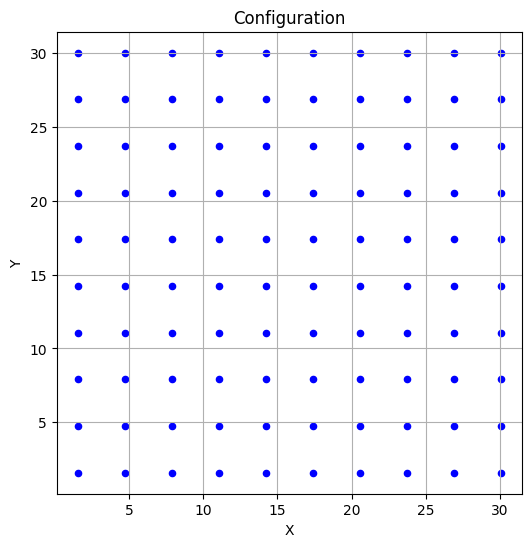

total atomic potential energy is: 561819.9701007587
total colloidal potential energy is: 7124005.7139325
total LJ potential energy is: 50241453.368991


In [96]:
def init_mc(rho:float,L:float,type:int)->np.ndarray:
    if type not in (0, 1):
        raise ValueError("Invalid value for 'type' parameter. It must be 0 or 1. 0 for random positions, 1 for ordered lattice")
    
    N = int(rho * L**2)
    n = int(np.sqrt(N))  
    
    if type==1:
        coordinates = np.zeros((n**2, 2))
        s = L / n
        shift=(L-(n-1)*s)/2

        k = 0
        for i in range(n):
            for j in range(n):
                coordinates[k] = [i * s+shift, j * s+shift]
                k += 1
                
        return coordinates
    
    if type==0:
        coordinates=np.zeros((N,2))
        count = 0
        while count < N:
            x = np.random.uniform(0, L)
            y = np.random.uniform(0, L)
            if count == 0:
                coordinates[count] = [x, y]
                count += 1
            else:
                distances = np.linalg.norm(coordinates[:count] - np.array([x, y]), axis=1)
                if np.all(distances >= 0.5):
                    #print(distances)
                    coordinates[count] = [x, y]
                    count += 1
                    
        return coordinates
        
def init_md(rho:float,L:float,T0:float,type:int)->list[np.ndarray]:
    if type not in (0, 1):
        raise ValueError("Invalid value for 'type' parameter. It must be 0 or 1. 0 for random positions, 1 for ordered lattice")
    
    N = int(rho * L**2)
    n = int(np.sqrt(N))  
    
    if type==1:
        coordinates = np.zeros((n**2, 2))
        s = L / n
        shift=(L-(n-1)*s)/2

        k = 0
        for i in range(n):
            for j in range(n):
                coordinates[k] = [i * s+shift, j * s+shift]
                k += 1
        
        velocities=np.zeros((n**2,2))
        for i in range(n**1):
            velocities[i][0]=np.random.normal(0, np.sqrt(T0))
            velocities[i][1]=np.random.normal(0, np.sqrt(T0))
        
        return [coordinates,velocities]
    
    if type==0:
        coordinates=np.zeros((N,2))
        velocities=np.zeros((N,2))
        
        count = 0
        while count < N:
            x = np.random.uniform(0, L)
            y = np.random.uniform(0, L)
            if count == 0:
                coordinates[count] = [x, y]
                velocities[count][0]=np.random.normal(0, np.sqrt(T0))
                velocities[count][1]=np.random.normal(0, np.sqrt(T0))
                count += 1
            else:
                distances = np.linalg.norm(coordinates[:count] - np.array([x, y]), axis=1)
                if np.all(distances >= 0.5):
                    #print(distances)
                    coordinates[count] = [x, y]
                    velocities[count][0]=np.random.normal(0, np.sqrt(T0))
                    velocities[count][1]=np.random.normal(0, np.sqrt(T0))
                    count += 1
                    
        return [coordinates,velocities]

def plot_configuration(coordinates: np.ndarray):
    plt.figure(figsize=(6, 6))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], color='b', s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Configuration')
    plt.grid(True)
    plt.show()
    
def plot_list_values(lst,listname,xlabel,ylabel):
    plt.plot(range(len(lst)), lst)
    plt.xlabel(str(xlabel))
    plt.ylabel(str(ylabel))
    plt.title(str(listname))

T1=0.728
rho1=0.8442
T2=1
rho2=0.1
T3=0.9
T4=2

box=9.1

init_config=init_mc(0.1,np.sqrt(100/0.1),1)
plot_configuration(init_config)
components=np.zeros_like(init_config)

#print(init_config)
print("total atomic potential energy is:",pairwise_potential(phi_A,init_config,box))
print("total colloidal potential energy is:",pairwise_potential(phi_C,init_config,box))
print("total LJ potential energy is:",pairwise_potential(lj_potential_cut,init_config,box))

In [5]:
import math
from decimal import Decimal
import os


def my_remainder(a:float,b:float):
    dec_b=Decimal(str(b))
    remainder=Decimal(str(a))%Decimal(str(b))
    if remainder<0:
        return float(remainder+dec_b)
    return float(remainder)



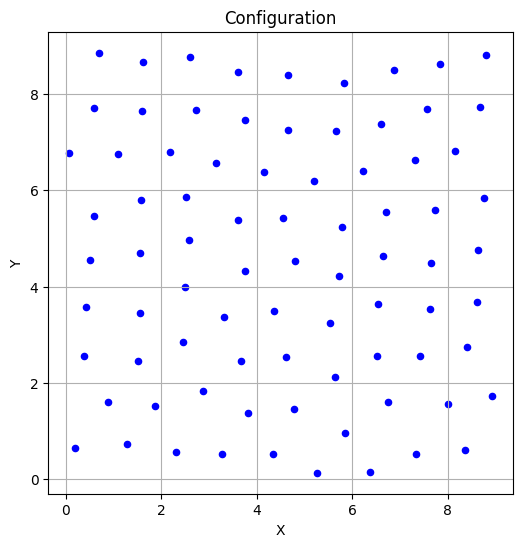

In [87]:
import random
from math import dist

def periodic_dist(a:np.ndarray,b:np.ndarray,box:float):
    dist=0
    for i in range(len(a)):
        if a[i]-b[i]<-box*0.5:
            dist+=(a[i]-b[i]+box)**2
        elif a[i]-b[i]>box*0.5:
            dist+= (a[i]-b[i]-box)**2
        else:
            dist+=(a[i]-b[i])**2

    return dist**0.5
        

def pairwise_potential_gradient(gradient: Callable[[float], float], box:float,xss:np.ndarray,gradient_components:np.ndarray) -> np.ndarray:
    """
    calculate the gradient of the total pairwise energy w.r.t. the particle coordinates.
    
    :param gradient: computes the magnitude of the gradient for a single pair
    :param xss: n x d array of particle coordinates
    :return: n x d array of the derivative of the total energy w.r.t. particle coordinates
    """
    
    n, d = xss.shape
    
    for i in range(n):
        for alpha in range(d):
            sum=0
            for j in range(n):
                if j!=i:
                    distance=periodic_dist(xss[i],xss[j],box)
                    if xss[i,alpha]-xss[j,alpha]<-box*0.5:
                        sum+=(xss[i,alpha]-xss[j,alpha]+box)/distance*gradient(distance)
                    elif xss[i,alpha]-xss[j,alpha]>box*0.5:
                        sum+=(xss[i,alpha]-xss[j,alpha]-box)/distance*gradient(distance)
                    else:
                        sum+=(xss[i,alpha]-xss[j,alpha])/distance*gradient(distance)
            gradient_components[i][alpha]=sum
            
    return gradient_components

def velocity_verlet(t_step:float,x:np.ndarray,v:np.ndarray,f_old:np.ndarray,f_new:np.ndarray,box:float,potential_gradient:Callable[[float],float]):
    f_old=-pairwise_potential_gradient(potential_gradient,box,x,f_old)
    
    n,d=x.shape
    
    for i in range(n):
        for j in range(d):
            x[i][j]=my_remainder(x[i][j]+v[i][j]*t_step+0.5*f_old[i][j]*t_step**2,box)
            
    f_new=-pairwise_potential_gradient(potential_gradient,box,x,f_new)
    v=v+(f_old+f_new)*0.5*t_step
    
def anderson(T:float,velocities:np.ndarray):
    N=velocities.shape[0]
    rand_index=np.random.randint(0, N)
    velocities[rand_index][0]=np.random.normal(0, np.sqrt(T))
    velocities[rand_index][1]=np.random.normal(0, np.sqrt(T))

def md_simulation(t_step:float,total_step:int,T:float,box:float,interval:float,coordinates:np.ndarray,velocities:np.ndarray):
    N=coordinates.shape[0]
    energies=list(range(total_step))
    f_old=np.zeros_like(velocities)
    f_new=np.zeros_like(velocities)
    
    step=0
    while step<total_step:
        flag=0

        count_before_collision=np.random.poisson(interval)
        for j in range(count_before_collision):
            energies[step]=pairwise_potential(phi_A,coordinates,box)
            velocity_verlet(t_step,coordinates,velocities,f_old,f_new,box,phi_A_derivative)
            step+=1
            if step==total_step:
                flag=1
                break
        if flag==1:
            break
            
        #anderson(T,velocities)

    plot_configuration(coordinates)
    return energies


def mc_simulation(total_step:int,T:float,box:float,sigma:float, coordinates: np.ndarray):
    # T is the temparature; sigma is the magnitude of random displacement
    N=coordinates.shape[0]
    energies=list(range(total_step))
    
    for i in range(total_step):
        e_old=pairwise_potential(phi_A,coordinates,box)
        rand_index=np.random.randint(0, N)
        displace_x=np.random.normal(0, sigma)
        displace_y=np.random.normal(0, sigma)
        coordinates[rand_index][0]=my_remainder((coordinates[rand_index][0]+displace_x),box)
        coordinates[rand_index][1]=my_remainder((coordinates[rand_index][1]+displace_y),box)
        e_new=pairwise_potential(phi_A,coordinates,box)
        
        random_number = random.random()   
        if random_number<np.exp(-(e_new-e_old)/T):
            energies[i]=e_new
        else:
            energies[i]=e_old
            coordinates[rand_index][0]=my_remainder((coordinates[rand_index][0]-displace_x),box)
            coordinates[rand_index][1]=my_remainder((coordinates[rand_index][1]-displace_y),box)
            
        
    plot_configuration(coordinates)
    return energies

total_step=4000
energies=mc_simulation(total_step,T3,box,0.08,init_config)



In [94]:
f=np.zeros_like(init_config)
def virial(configuration:np.ndarray,f:np.ndarray,box,potential_gradient:Callable[[float],float]):

    f=-pairwise_potential_gradient(potential_gradient,box,configuration,f)
    virial=np.dot(configuration.flatten(),f.flatten())
    return virial

def pressure(configuration:np.ndarray,f,rho:float,T:float,box:float,potential_gradient:Callable[[float],float]):
    return rho*T+1/(2*box**2)*virial(configuration,f,box,potential_gradient)

print(pressure(init_config,f,1,T3,box,phi_A_derivative))

-1.3773296466911908


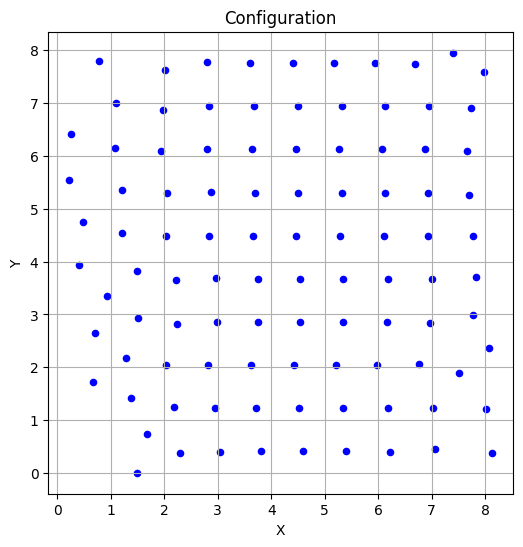

[33.62518720371981]


In [129]:
rhos=[1.5]
boxs=[np.sqrt(100/rhoi) for rhoi in rhos]
ps=list(range(len(boxs)))

for k in range(len(rhos)):
    [init_config,init_v]=init_md(rhos[k],boxs[k],0.4*T4,1)
    f=np.zeros_like(init_config)
    md_simulation(0.008,200,T4,boxs[k],3,init_config,init_v)
    ps[k]=pressure(init_config,f,rhos[k],T4,boxs[k],phi_A_derivative)
    
print(ps)

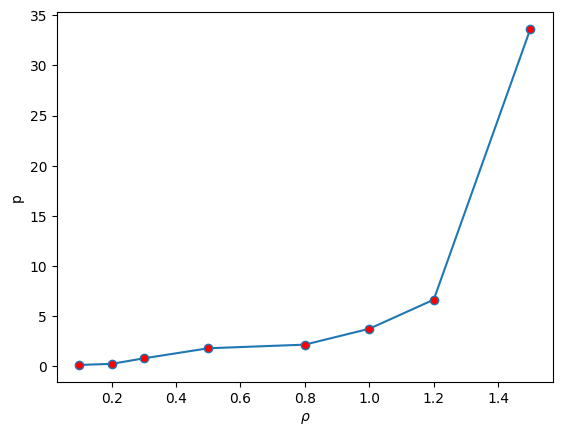

In [133]:
rhos=[0.1,0.2,0.3,0.5,0.8,1.0,1.2,1.5]
ps=[-0.016115686323797715, 0.05721360623075861, 0.0013657600225362443, -1.3246853524000355, -0.3476842377889072, -0.1340736950182656,  2.131356500884781, 4.670888802258144]
ps2=[0.15585135490878335, 0.2600090620398054, 0.8137994612523571, 1.8141906504340455, 2.1767430892099346, 3.758871993692577, 6.656986656096731, 33.62518720371981]

plt.plot(rhos,ps2,marker='o',markerfacecolor='red')
plt.xlabel("$\\rho$")
plt.ylabel("p")

def count_within(configuration:np.ndarray,box:float,r:float):
    N=configuration.shape[0]
    rand_index=np.random.randint(0,N)
    
    count =0
    for i in range(N):
        if i !=rand_index and periodic_dist(configuration[i],configuration[rand_index],box)<=r:
            count+=1
    
    return count

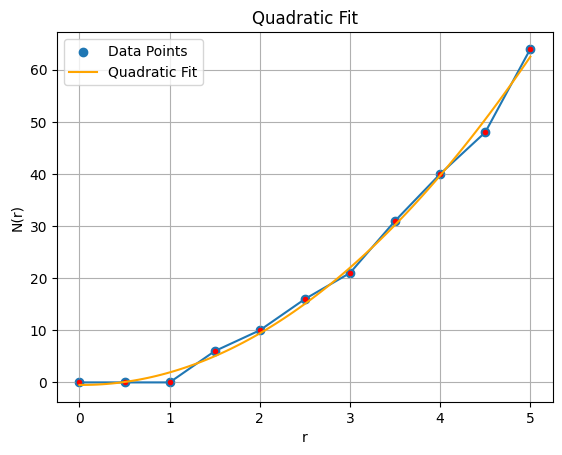

[ 2.55011655 -0.15058275 -0.48251748]
R-squared value: 0.9965969641514436


In [103]:
cumul=[count_within(init_config,box,i*0.5) for i in range(0,11)]
dist=[i*0.5 for i in range(0,11)]

plt.plot(dist,cumul,marker='o',markersize=5, markerfacecolor='red')
plt.xlabel("r")
plt.ylabel("N(r)")
plt.title("cumulative distribution")

coefficients = np.polyfit(dist, cumul, 2)
quadratic_function = np.poly1d(coefficients)

x_fit = np.linspace(min(dist), max(dist), 100)
y_fit = quadratic_function(x_fit)


plt.scatter(dist, cumul, label='Data Points')
plt.plot(x_fit, y_fit, label='Quadratic Fit', color='orange')
plt.xlabel('r')
plt.ylabel('N(r)')
plt.title('Quadratic Fit')
plt.legend()
plt.grid(True)
plt.show()
print(coefficients)

y_predicted = quadratic_function(dist)
residuals = cumul - y_predicted
ss_residuals = np.sum(residuals**2)
mean_y = np.mean(cumul)
ss_total = np.sum((cumul- mean_y)**2)

# Calculate the R-squared value
r_squared = 1 - (ss_residuals / ss_total)

print("R-squared value:", r_squared)

-100.47169770502465
-100.47169770502465
-1.2403913296916624
3.5376501294158516
-0.018720338567546967


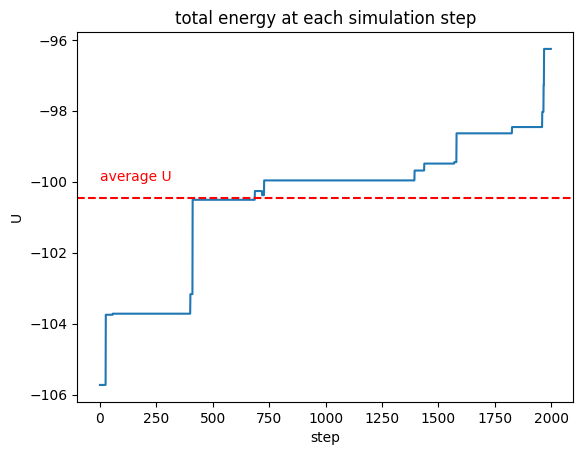

In [82]:
energies_trunc=energies[0:]
plot_list_values(energies_trunc,"total energy at each simulation step","step","U")
length = len(energies_trunc)
ave_energy=sum(energies_trunc)/length
plt.axhline(y=ave_energy, color='red', linestyle='--')
plt.text(0, ave_energy+0.5, 'average U', color='red')
print(ave_energy)


ave_energy_trunc=sum(energies_trunc)/len(energies_trunc)
print(ave_energy_trunc)
print(ave_energy_trunc/init_config.shape[0])
squared_energies_trunc = list(map(lambda x: x**2, energies_trunc))
fluc_energy=sum(squared_energies_trunc)/len(energies_trunc)-ave_energy_trunc**2
print(fluc_energy)
print(fluc_energy**0.5/ave_energy_trunc)

In [1]:
derivative_function = quadratic_function.deriv()
print("Original function:", quadratic_function)
print("Derivative function:", derivative_function)
g_fit=(init_config.shape[0]-1)/(init_config.shape[0]*2*np.pi*init_config.shape[0]/box**2)*derivative_function(x_fit)
plt.plot(x_fit, g_fit, label='Quadratic Fit', color='orange')

NameError: name 'quadratic_function' is not defined

In [ ]:
size=[9,25,16,36,49,64,81,100,121,225]
U=[-12.792,-45.938,-26.735,-70.667,-100.504,-129.624,-159.867,-197.440,-237.425,-492.546]
deviation=[1.850,6.962,3.664,9.020,26.248,22.964,32.040,148.627,36.383,418.802]
plt.figure(figsize=(6, 6))
plt.scatter(np.array(size), U, color='r', s=20)
plt.xlabel('size')
plt.ylabel('U')
plt.title('U-size')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(1/np.array(size), deviation, color='r', s=20)
plt.xlabel('1/size')
plt.ylabel('deviation')
plt.title('deviation-1/size')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(1/np.array(size), [-deviation[i]/U[i] for i in range(len(U))], color='r', s=20)
plt.xlabel('1/size')
plt.ylabel('deviation')
plt.title('deviation-1/size')
plt.grid(True)
plt.show()

In [ ]:
energies_md_trunc=energies_md[0:]
plot_list_values(energies_md_trunc,"total energy at each simulation step","step","U")
length = len(energies_md_trunc)
ave_energy=sum(energies_md_trunc)/length
plt.axhline(y=ave_energy, color='red', linestyle='--')
plt.text(0, ave_energy+0.5, 'average U', color='red')
print(ave_energy)


ave_energy_trunc=sum(energies_md_trunc)/len(energies_md_trunc)
print(ave_energy_trunc)
print(ave_energy_trunc/init_config.shape[0])
squared_energies_trunc = list(map(lambda x: x**2, energies_md_trunc))
fluc_energy=sum(squared_energies_trunc)/len(energies_md_trunc)-ave_energy_trunc**2
print(fluc_energy)
print(fluc_energy**0.5/ave_energy_trunc)

-2.6735125358882716


/var/folders/26/33gfkypd2f930_67mdqmxs8m0000gn/T/ipykernel_68523/1449256468.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  g=[(5.10*r[i]-0.151)/r[i]*(init_config.shape[0]-1)/init_config.shape[0]/rho1/(2*np.pi)*np.exp(-phi_A(r[i])/T1) for i in range(len(r))]
/var/folders/26/33gfkypd2f930_67mdqmxs8m0000gn/T/ipykernel_68523/506055591.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  r2=1/r**2
/var/folders/26/33gfkypd2f930_67mdqmxs8m0000gn/T/ipykernel_68523/1449256468.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  g=[(5.10*r[i]-0.151)/r[i]*(init_config.shape[0]-1)/init_config.shape[0]/rho1/(2*np.pi)*np.exp(-phi_A(r[i])/T1) for i in range(len(r))]


Text(0, 0.5, 'g with Boltzmann factor')

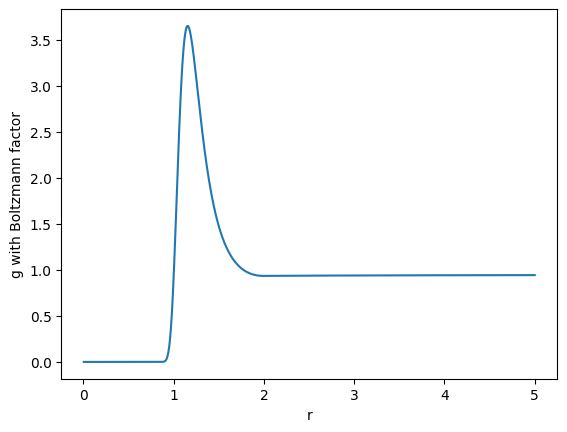

In [48]:
r=np.linspace(0.000001,2.5,9000)
integral=0

for i in range(len(r)-1):
    integral+=np.exp(-phi_A((r[i]+r[i+1])/2))*np.pi*rho1*(r[i]*phi_A(r[i])*0.984+r[i+1]*phi_A(r[i+1])*0.984)/2*(r[i+1]-r[i])
print(integral)

r=np.linspace(0,5,1000)
g=[(5.10*r[i]-0.151)/r[i]*(init_config.shape[0]-1)/init_config.shape[0]/rho1/(2*np.pi)*np.exp(-phi_A(r[i])/T1) for i in range(len(r))]

plt.plot(r,g)
plt.xlabel("r")
plt.ylabel("g with Boltzmann factor")

In [142]:
8*np.pi*rho1**2/3*(3/5/2**10-3/4/2**4)

-0.276367955429151